In [19]:
import glob
# from slab import *
import PyInventor
from PyInventor import *
import pyEPR as epr
from pyEPR import ansys as HFSS
import numpy as np

%matplotlib notebook

import pandas as pd
import pyEPR
from pyEPR import ansys as HFSS

import scipy
from scipy import constants as const

from pint import UnitRegistry
ureg = UnitRegistry()
Q = ureg.Quantity
import os

# Some useful functions

In [21]:
'''
Some code for frequency estimation
'''

class unique_element:
    def __init__(self,value,occurrences):
        self.value = value
        self.occurrences = occurrences
        
def perm_unique(elements):
    eset=set(elements)
    listunique = [unique_element(i,elements.count(i)) for i in eset]
    u=len(elements)
    return perm_unique_helper(listunique,[0]*u,u-1)

def perm_unique_helper(listunique,result_list,d):
    if d < 0:
        yield tuple(result_list)
    else:
        for i in listunique:
            if i.occurrences > 0:
                result_list[d]=i.value
                i.occurrences-=1
                for g in  perm_unique_helper(listunique,result_list,d-1):
                    yield g
                i.occurrences+=1

def TE_mode_sort(mode_num=1):
    '''
    This calculates allowable nml values for the TE modes of the resonator. Uses above functions
    '''
    
    permutes=[[1,0,1],[1,0,2],[1,0,3],[1,0,4],[1,0,5],[2,0,2],[2,0,3],[2,0,4],[2,0,5],[3,0,3],[3,0,4],[3,0,5]]
    nml=[]
    for i in range(len(permutes)):
        perms=np.array(list(perm_unique(permutes[i])))
        for vals in perms:
            if vals[0]!=0 and vals[1]==0 and vals[2]!=0:
                nml.append(list(vals))
            else:
                pass
    nml=np.array(nml)
    i_sort=np.argsort(nml[:,0])
    return nml[i_sort][0:mode_num]


def freq_rect(a,b,c, modes=1, unit='metric'):
    '''
    Calculate the lowest n-mode frequencies for a rectangular cavity of a,b,c dimensions where b is the smallest dim
    '''
    if unit=='metric':
        a=a/1000.
        b=b/1000.
        c=c/1000.
    elif unit=='imperial':
        a=a*.0254
        b=b*.0254
        c=c*.0254
    else:
        raise Exception('ERROR: Unit must be metric or imperial')
    
    eps=const.epsilon_0
    mu=const.mu_0
    c_speed=const.c
    nml_array=TE_mode_sort(10)
    f=[]

    for vals in nml_array:
        n=vals[0]
        m=vals[1]
        l=vals[2]
        f.append(((c_speed)/(2*pi))*sqrt((n*pi/a)**2+(m*pi/b)**2+(l*pi/c)**2))
    f=np.array(f)
    f_sort=np.argsort(f)
    return f[f_sort][0:modes], nml_array[f_sort]

def get_c_dim(f,a,b, unit='metric'):
    '''
    Estimates the second long dimension based on a target frequency and the other two dimensions. Works only for the 
    fundamental mode
    '''
    brentq=scipy.optimize.brentq
    f_intercept=lambda c:freq_rect(a,b,c,1, unit)[0][0]-f
    c=brentq(f_intercept, min([10*a, b]), max([10*a, b]))

    return c

def round_dim(dim, frac):
    val=frac*math.ceil(dim/frac)+frac
    if (val-dim)/2<frac:
        val=val+.25
    else:
        pass
    return val

def val_gen(val_in, units='metric', scale='mm'):
    if units=='imperial':
        fac=1
        unit='in'
    elif units=='metric':
        if scale=='mm':
            fac=25.4
        elif scale=='m':
            fac=.0254
    else:
        raise Exception('Wrong unit val')
        
    if type(val_in)==list:
        for I, val in enumerate(val_in):
            val_in[I]=fac*val
    else:
        val_in=fac*val_in
    
    return val_in

def check_path(path):
    check=glob.glob(path)
    if check==[]:
        return False
    else:
        return True

def cap_sigma(cmat, units='fF'):
    cmat=Q(cmat, units).to('F').magnitude
    c11=abs(cmat[0,0])-abs(cmat[0,1])
    c22=abs(cmat[1,1])-abs(cmat[1,0])
    c12=abs(cmat[0,1])/2+abs(cmat[1,0])/2
    return (c12+(c11*c22)/(c11+c22))

def C_to_Ec(cmat, cap_units='fF'):
    csig=cap_sigma(cmat, cap_units)
    return const.e**2/(2*(csig))/const.h

def Ec_to_C(Ec):
    Ec = Ec*const.h
    return const.e**2/(2*Ec)

def L_from_nu_and_C(nu,C):
    return (1/nu**2/4/np.pi**2/C)

# Cavity creation Inventor

In [3]:
'''
Coaxial cavity example showing the use of the revolve command.
'''
#function that closes open files. Useful if you are trying to troubleshoot and don't want to
#keep opening new files every time.
com_obj().close_all_parts()

#set document units
units='imperial'

#set it to overwrite file every time the part is instantiated (REMEMBER TO PUT SAVE AT THE BOTTOM!)
overwrite=True

#filename
fname='coax_test.ipt'

#path
#path='S:\\Andrew Oriani\\CQED 3D Resonators\\Multimode Manipulate Cavity\\3D MM V3'

#for demo set the path to path='' to save in current working directory
path=''

#setup part 
part=iPart(path=path, prefix=fname, units=units, overwrite=overwrite)

#set view as wireframe with hidden edges
part.set_visual_style(shaded=False, edges=True, hidden_edges=True)

#create workplane for the revolved sketch
revolve_wp=part.add_workplane(plane='xz')

height=2
cyl_radius=.5
cav_radius = 0.3
cav_depth = 1.85
pin_height = 0.231

#create workplane for the stock. Notice that teh revolved feature plane is perpendicular to this
stock_wp=part.add_workplane(plane='xy', offset=height)

#create a sketch for the stock top
stock_sketch=part.new_sketch(stock_wp)

#create a new sketch for the revolved feature geometry
revolve_sketch=part.new_sketch(revolve_wp)

#create a structure for the revolved feature geometry. Notice the starting point
s=structure(part, revolve_sketch, start=(0 ,height))

#draw the outline of the cavity interior. Only 1/2 has to be drawn

s.add_line(cav_radius, 180)
s.add_line(cav_depth, 270)
s.add_line_arc(start_angle=180, stop_angle=0, radius=.094, flip_dir=True, rotation=0)
s.add_line(pin_height, 90)
s.add_line_arc(start_angle=0, stop_angle=270, radius=.0625, flip_dir=False, rotation=180)
s.add_line(.038+.0115, 0)

#draw path in the inventor file. Path must be closed for the proper revolution
rev_path=s.draw_path(close_path=True)

#draw the circle that defines the stock diameter. Return object collection that can be used to 
#select in the extrussion step
stock_top_circle=part.sketch_circle(stock_sketch, center=(0,0), radius=cyl_radius)

#Extrude part. Notice we are explicitely selecting the circle object from this sketch
re=part.extrude(stock_sketch, thickness=2, obj_collection=stock_top_circle, direction='negative', operation='join')

#Now that there is a solid to reolve a part out of, we can rotate the cavity interior geometry
#The revolution axis must be in plane with the xy plane. In are case we select the y axis. Here
#the axis is set at y=0, however an arbitrary axis can be set
rv=part.revolve_full(revolve_sketch, axis='z', obj_collection=rev_path, operation='cut')


part.view.GoHome()

#Save document 
part.save()

#save copy as stp file for export to HFSS
path=part.save_copy_as(copy_name='coax_test.stp' )

File successfully copied as: C:\_Lib\python\Automated-RF-Design\3D Cavity Demonstrations\00000_coax_test.stp


# Cavity simulation alone

In [4]:
project_name='Coax_Test'
design_name='Coax'
overwrite=True

#use local path
# HFSS_path="C:\\Users\\Tantalum\\Documents\\Ansoft\\Local Simulation Files"

#use file location path:
HFSS_path=os.getcwd()

full_path=HFSS_path+'\\Simulation Files\\'+project_name+'.aedt'

HFSS_app=HFSS.HfssApp()
HFSS_desktop=HFSS_app.get_app_desktop()

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        EM_design=project.new_em_design(design_name)
    else:
        EM_design=project.get_design(design_name)
        
else:
    EM_design=project.new_em_design(design_name)

EM_design.make_active()
model=HFSS.HfssModeler(EM_design)
model.import_3D_obj(path)

Stock_H=EM_design.create_variable('Stock_H', '%.3fin'%(height))
Cyl_R=EM_design.create_variable('Cyl_R', "%.4fin"%cyl_radius)
center_pos=[0,0,Stock_H/2]
axis="Z"

cyl_1=model.draw_cylinder_center(center_pos, Cyl_R, Stock_H, axis)

objs=model.get_object_names()
obj_name=model.subtract(blank_name=objs[1], tool_names=[objs[0]])

top_id=model.get_face_id_by_pos(obj='Cylinder1', pos=[0,0,Stock_H])

model.assign_impedance(377, 0, obj_name, top_id)

EM_setup=EM_design.create_em_setup(name="Test_EM", min_freq_ghz=2, n_modes=2, max_delta_f=0.1)
EM_setup.analyze()
solns=EM_setup.get_solutions()

eigen_real=solns.eigenmodes()[0]
eigen_imag=solns.eigenmodes()[1]


calc=HFSS.HfssFieldsCalc(EM_setup)

calc.clear_named_expressions()

#be sure to change path to wher ethe S_v and S_m calcs are
Se_calc_path=HFSS_path+"\\HFSS Calculators\\E_energy_S_to_V.clc"
Sm_calc_path=HFSS_path+"\\HFSS Calculators\\H_energy_S_to_V.clc"

Se_name=calc.load_named_expression(Se_calc_path)
Sm_name=calc.load_named_expression(Sm_calc_path)

print('Eigenmodes:')
print('_____________________________')
for n, (em_real, em_imag) in enumerate(zip(eigen_real, eigen_imag)):
    print('Mode #%i: %.3f+i%.3e GHz'%(n+1, em_real, em_imag))

print('_____________________________')

n_modes=2
Se=[]
Sm=[]
for n in range(1,n_modes+1):
    solns.set_mode(n)
    Se.append(calc.use_named_expression(Se_name).evaluate())
    Sm.append(calc.use_named_expression(Sm_name).evaluate())
    print('Se=%.3f, Sm=%.3f for mode number %i'%(Se[-1], Sm[-1], n))


INFO 07:40PM [analyze]: Analyzing setup Test_EM


Eigenmodes:
_____________________________
Mode #1: 6.545+i3.388e-10 GHz
Mode #2: 11.872+i5.500e-02 GHz
_____________________________
Se=384.906, Sm=562.249 for mode number 1
Se=188.237, Sm=406.676 for mode number 2


# pyEPR

In [5]:
project_name='Coax_Test'
design_name='Coax_EPR'
overwrite=True

#use local path
# HFSS_path="C:\\Users\\Tantalum\\Documents\\Ansoft\\Local Simulation Files"

#use file location path:
HFSS_path=os.getcwd()

full_path=HFSS_path+'\\Simulation Files\\'+project_name+'.aedt'

HFSS_app=HFSS.HfssApp()
HFSS_desktop=HFSS_app.get_app_desktop()

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        EM_design=project.new_em_design(design_name)
    else:
        EM_design=project.get_design(design_name)
        
else:
    EM_design=project.new_em_design(design_name)

EM_design.make_active()
model=HFSS.HfssModeler(EM_design)
model.import_3D_obj(path)

Stock_H=EM_design.create_variable('Stock_H', '%.3fin'%(height))
Cyl_R=EM_design.create_variable('Cyl_R', "%.4fin"%cyl_radius)
cav_R=EM_design.create_variable('cav_R', "%.4fin"%cav_radius)

center_pos=[0,0,Stock_H/2]
axis="Z"

cyl_1=model.draw_cylinder_center(center_pos, Cyl_R, Stock_H, axis)

objs=model.get_object_names()
obj_name=model.subtract(blank_name=objs[1], tool_names=[objs[0]])

top_id=model.get_face_id_by_pos(obj='Cylinder1', pos=[0,0,Stock_H])

model.assign_impedance(377, 0, obj_name, top_id)

coupler_hole_depth = 0.4
coupler_hole_cav_ovlap = 0.1
coupler_hole_height = 0.4

Q_hole_len=EM_design.create_variable('Q_hole_len', "%.3fin"%(coupler_hole_depth))
Q_hole_dia=EM_design.create_variable('Q_hole_dia', "%.3fin"%.125)

Q_hole_x=EM_design.create_variable('Q_hole_loc_x',"%.3fin"%(cav_radius-coupler_hole_cav_ovlap))
Q_hole_y=EM_design.create_variable('Q_hole_loc_y', 0)
Q_hole_z=EM_design.create_variable('Q_hole_loc_z', "%.3fin"%(coupler_hole_height))
Q_hole_loc=[Q_hole_x, Q_hole_y, Q_hole_z]

#create qubit hole
Q_hole=model.draw_cylinder(pos=Q_hole_loc, radius=Q_hole_dia/2, height= Q_hole_len, axis='X', name='Q_Hole')
obj_name=model.unite([obj_name, Q_hole])

#chip dimensions and location
chip_L = 15
chip_W = 2 
Q_chip_x_offset=EM_design.set_variable('Q_chip_x_offset', '%.3fin'%0.25)#<---Changing this offset value will change how
                                                                         #    far the chip is from the center pin 
Chip_W=EM_design.set_variable('Chip_W', '%.3fmm'%2)
Chip_L=EM_design.set_variable('Chip_L', '%.3fmm'%(15))
Chip_H=EM_design.set_variable('Chip_H','%.3fmm'%0.4)

#create some variables for the qubit hole location
Q_chip_x=EM_design.set_variable('Q_chip_loc_x', Q_chip_x_offset+Chip_L/2)
Q_chip_y=EM_design.set_variable('Q_chip_loc_y',0)
Q_chip_z=EM_design.set_variable('Q_chip_loc_z', Q_hole_z)

chip_pos=[Q_chip_x, Q_chip_y, Q_chip_z]
chip_dims=[Chip_L, Chip_W, Chip_H]
chip_sub=model.draw_box_center(chip_pos, chip_dims, name='Chip_sub')
obj_name=model.unite([obj_name, chip_sub])

# Add Sapphire chip
chip=model.draw_box_center(chip_pos, chip_dims, name='Chip', material='Sapphire')

#setup pad locations and with relation to chip
Pad_x_offset=EM_design.set_variable('pad_x_offset', '%.3fmm'%.5)
Pad_L=EM_design.set_variable('pad_l', '%.3fmm'%0.8)
Pad_W=EM_design.set_variable('pad_w', '%.3fum'%350)
Pad_gap=EM_design.set_variable('pad_gap', '%.3fum'%100)

Pad_x=EM_design.set_variable('pad_x', Q_chip_x+Pad_x_offset-Chip_L/2)
Pad_y=EM_design.set_variable('pad_y', Q_chip_y-Pad_W/2)
Pad_z=EM_design.set_variable('pad_z', Q_chip_z+Chip_H/2)
Junc_W=EM_design.set_variable('jj_w', '%.3fum'%50)
junc_L=EM_design.get_variable_value(Pad_gap)

pad_loc=[Pad_x, Pad_y, Pad_z]

#we'll need this for later



#junction width
Pad_x_2=EM_design.set_variable('pad_x_2', Pad_x+Pad_L+Pad_gap)
pad_loc_2=[Pad_x_2, Pad_y, Pad_z]

#create both pad. We could also duplicate along line
pad_1=model.draw_rect_corner(pos=pad_loc, x_size=Pad_L, y_size=Pad_W, name='Pad_1')
pad_2=model.draw_rect_corner(pos=pad_loc_2, x_size=Pad_L, y_size=Pad_W, name='Pad_2')

#make junction
Junc_x=EM_design.set_variable('junc_x', Pad_x+Pad_L)
Junc_y=EM_design.set_variable('junc_y', Pad_y+(Pad_W-Junc_W)/2)

junc_loc=[Junc_x, Junc_y, Pad_z]
jj=model.draw_rect_corner(pos=junc_loc, x_size=Pad_gap, y_size=Junc_W, name='jj')

#set boundaries of pads
model.assign_perfect_E([pad_1, pad_2], name='TPads')

#set jj to lumped RLC, but first create a variable for L_jj
Lj_val=8.0  #<---this sets the nominal Lj_val

L_jj=EM_design.set_variable('Lj_1', '%.3fnH'%Lj_val)
jj.make_rlc_boundary(axis='Y', r=0, l=L_jj, c=0, name='jj1_RLC')

#Need an integration line for pyEPR. Not necessary for our single qubit case but won't work without
#it for some reason. Closed needs to be false in order for itto be recognized as line object
jj_line=model.draw_polyline(jj.make_center_line(axis='Y'), closed=False, name='jj_line')

#do some meshing to better sample the E-field of the qubit and pads
model.mesh_length(name_mesh='jj', objects=[jj], MaxLength='%.3fum'%20)
model.mesh_length(name_mesh='pads', objects=[pad_1, pad_2], MaxLength='%.3fum'%100)
model.mesh_length(name_mesh='substrate', objects=[chip], MaxLength='%.3fmm'%1)

#setup the analysis and optimetrics
opti_setup=HFSS.Optimetrics(EM_design)

#note that the eigenmode (EM) setup has to be made first
EM_setup=EM_design.create_em_setup(name='Qubit_EM', 
                                   min_freq_ghz=0.5, 
                                   n_modes=3, 
                                   max_delta_f=0.5, 
                                   min_converged=1, 
                                   max_passes=20,
                                   converge_on_real=True)

#set the optimetrics step size and number of steps
step=.2
num_step=1

#create optimetrics setup
opti_setup.create_setup(variable=L_jj,
                        swp_params=('%.2fnH'%(Lj_val-num_step*step), '%.2fnH'%(Lj_val+num_step*step), '%.2fnH'%step),
                        name='Lj_Sweep',
                        solve_with_copied_mesh_only=False
                        )

#solve it
opti_setup.solve_setup('Lj_Sweep')

#save project
project.save()

#in anticipation of pyEPR we run the project info to reopen the project for EPR analysis

pinfo=pyEPR.ProjectInfo(HFSS_path,  
                         project_name,
                         design_name)


ERROR 07:41PM [mesh_length]: KEY `{key}` NOT IN ops!
ERROR 07:41PM [mesh_length]: KEY `{key}` NOT IN ops!
ERROR 07:41PM [mesh_length]: KEY `{key}` NOT IN ops!


Inserting optimetrics setup `Lj_Sweep` for simulation setup: `Qubit_EM`


INFO 08:17PM [connect]: Connecting to Ansys Desktop API...
INFO 08:17PM [load_ansys_project]: 	File path to HFSS project found.
INFO 08:17PM [load_ansys_project]: 	Opened Ansys App
INFO 08:17PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 08:17PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/_Lib/python/Automated-RF-Design/3D Cavity Demonstrations/Simulation Files/
	Project:   Coax_Test
INFO 08:17PM [connect]: 	Opened active design
	Design:    Coax_EPR [Solution type: Eigenmode]
INFO 08:17PM [get_setup]: 	Opened setup `Qubit_EM`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:17PM [connect]: 	Connection to Ansys established successfully. 😀 



In [9]:
'''
pyEPR analysis. 

Once the variations have been calculated we can proceed to do the EPR analysis. The following loads the above into the
pinfo object used by pyEPR for 

'''

#make sure you use the correct variable names otherwise this will not work correctly
pinfo.junctions['j1'] = {'Lj_variable' : str(L_jj), 
                         'rect'        : str(jj),  
                         'line'        : str(jj_line),
                         'length'      : pyEPR.parse_units(junc_L)}

project=pinfo.project


#this just makes sure everything is kosher (copacetic if you are Vatsan)
pinfo.validate_junction_info()

# #setup for EPR anaylsis
eprh = pyEPR.DistributedAnalysis(pinfo)

Design "Coax_EPR" info:
	# eigenmodes    3
	# variations    3


In [10]:
'''
Taken from the pyEPR tutorial, just checks the analysis folders for the various variations
'''

for variation in eprh.variations[:2]: # just for the first 2
    Fs, Qs = eprh.get_freqs_bare_pd(variation=variation, frame=False)
    display(pd.DataFrame({'Freq. (GHz)':Fs, 'Quality Factor':Qs}))

,Freq. (GHz),Quality Factor
0,3.194783,1.015920e+13
1,6.578086,1.645336e+10
2,11.832040,2.077954e+02


,Freq. (GHz),Quality Factor
0,3.071309,1.182072e+13
1,6.567686,1.564447e+10
2,11.831936,2.118661e+02


In [11]:
# Do EPR analysis for all modes and all variations 
# If you want to only analze a certain variation, you can change the 
# default keyword argeumetns variations=None, modes=None
eprh.do_EPR_analysis(variations=None, modes=None);


Variation 0  [1/3]

  Mode 0 at 3.19 GHz   [1/3]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.4%  2.357e-23 1.524e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 99.38%
	j1              6.49041e-09  (+)        4.0798e-11
		(U_tot_cap-U_tot_ind)/mean=98.71%

  Mode 1 at 6.58 GHz   [2/3]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.0%  9.948e-20 9.944e-20

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.40%
	j1              8.49571e-12  (+)        2.26403e-13
		(U_tot_cap-U_tot_ind)/mean=0.02%

  Mode 2 at 11.83 GHz   [3/3]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E     

	 Differences in variations:


variation,0,1,2
_Lj_1,7.7999999999999998nH,8nH,8.1999999999999993nH


ERROR 08:21PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 197.4% is > 15%.                     
Is the simulation converged? Proceed with caution





 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization


ERROR 08:22PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 197.4% is > 15%.                     
Is the simulation converged? Proceed with caution


Pm_norm=
modes
0    1.520931e+08
1    2.204317e+07
2    4.987395e+06
dtype: float64

Pm_norm idx =
      j1
0  False
1  False
2  False

*** Different parameters


_Lj_1    7.7999999999999998nH
Name: 0, dtype: object

ERROR 08:22PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 197.7% is > 15%.                     
Is the simulation converged? Proceed with caution




*** P (participation matrix, not normlz.)
             j1
0  6.490407e-09
1  8.495708e-12
2  1.814525e-11

*** S (sign-bit matrix)
   s_j1
0     1
1     1
2     1
*** P (participation matrix, normalized.)
   6.5e-09
   8.5e-12
   1.8e-11

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
  2.56e-15 1.38e-17 5.31e-17
  1.38e-17 1.86e-20 1.43e-19
  5.31e-17 1.43e-19 2.75e-19

*** Chi matrix ND (MHz) 
        -0       -0       -0
        -0       -0       -0
        -0       -0       -0

*** Frequencies O1 PT (MHz)
0     3194.783418
1     6578.086198
2    11832.039585
dtype: float64

*** Frequencies ND (MHz)
0     3194.783418
1     6578.086198
2    11832.039585
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1, 2]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 1

Starting the diagonalization
Finished the diagonalization


ERROR 08:22PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 197.7% is > 15%.                     
Is the simulation converged? Proceed with caution


Pm_norm=
modes
0    1.314683e+06
1    7.066252e+05
2    7.183157e+06
dtype: float64

Pm_norm idx =
      j1
0  False
1  False
2  False

*** Different parameters


_Lj_1    8nH
Name: 1, dtype: object

ERROR 08:22PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 197.8% is > 15%.                     
Is the simulation converged? Proceed with caution




*** P (participation matrix, not normlz.)
             j1
0  7.518899e-07
1  8.904836e-10
2  5.175136e-11

*** S (sign-bit matrix)
   s_j1
0     1
1     1
2     1
*** P (participation matrix, normalized.)
   7.5e-07
   8.9e-10
   5.2e-11

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
  3.26e-11 1.65e-13 1.73e-14
  1.65e-13 2.09e-16 4.38e-17
  1.73e-14 4.38e-17 2.29e-18

*** Chi matrix ND (MHz) 
        -0       -0       -0
        -0       -0       -0
        -0       -0       -0

*** Frequencies O1 PT (MHz)
0     3071.308582
1     6567.686480
2    11831.935855
dtype: float64

*** Frequencies ND (MHz)
0     3071.308582
1     6567.686480
2    11831.935855
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1, 2]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 2

Starting the diagonalization
Finished the diagonalization


ERROR 08:22PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 197.8% is > 15%.                     
Is the simulation converged? Proceed with caution


Pm_norm=
modes
0    1.315941e+06
1    6.873386e+05
2    1.878411e+06
dtype: float64

Pm_norm idx =
      j1
0  False
1  False
2  False

*** Different parameters


_Lj_1    8.1999999999999993nH
Name: 2, dtype: object



*** P (participation matrix, not normlz.)
             j1
0  7.513843e-07
1  9.067355e-10
2  1.586661e-10

*** S (sign-bit matrix)
   s_j1
0     1
1     1
2     1
*** P (participation matrix, normalized.)
   7.5e-07
   9.1e-10
   1.6e-10

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
  3.26e-11  1.7e-13 5.37e-14
   1.7e-13 2.22e-16  1.4e-16
  5.37e-14  1.4e-16 2.21e-17

*** Chi matrix ND (MHz) 
        -0       -0       -0
        -0       -0       -0
        -0       -0       -0

*** Frequencies O1 PT (MHz)
0     3033.847147
1     6567.680132
2    11831.086322
dtype: float64

*** Frequencies ND (MHz)
0     3033.847147
1     6567.680132
2    11831.086322
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1, 2]


<IPython.core.display.Javascript object>


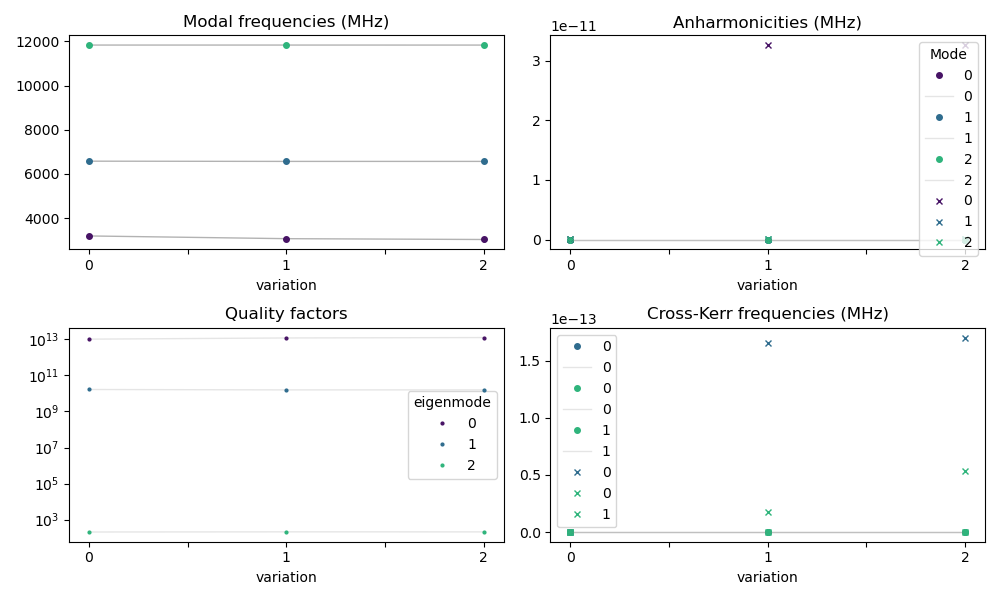

In [12]:
# This is the core object for working with post processing data from HFSS
# This iwll load the saved solutions from above
epra = pyEPR.QuantumAnalysis(eprh.data_filename)

# Analyze 
epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 15);
epra.plot_hamiltonian_results();

In [14]:
#Custom sort of columns
def do_sort_index(df:pd.DataFrame):
    if isinstance(df, pd.DataFrame):
        df.columns = df.columns.astype(float)
        return df.sort_index(axis=1)
    else:
        return df

epra.results.do_sort_index = do_sort_index
df = epra.results.get_frequencies_HFSS(vs='Lj_1')
df

Lj_1,7.8,8.0,8.2
eigenmode,,,
0,3194.783418,3071.308582,3033.847147
1,6578.086198,6567.686480,6567.680132
2,11832.039585,11831.935855,11831.086322


# Q3D

In [15]:
'''
Q3D setup to determine the Ec of the qubit pads
'''

project_name='Coax_Test'
design_name='Coax_Q3D'
overwrite=True

#use file location path:
HFSS_path=os.getcwd()

full_path=HFSS_path+'\\Simulation Files\\'+project_name+'.aedt'

HFSS_app=HFSS.HfssApp()
HFSS_desktop=HFSS_app.get_app_desktop()

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        q3d_design=project.new_q3d_design(design_name)
    else:
        q3d_design=project.get_design(design_name)
        
else:
    q3d_design=project.new_q3d_design(design_name)
        
q3d_design.make_active()
model=HFSS.HfssModeler(q3d_design)
model.import_3D_obj(path)


Stock_H=q3d_design.create_variable('Stock_H', '%.3fin'%(height))
Cyl_R=q3d_design.create_variable('Cyl_R', "%.4fin"%cyl_radius)
cav_R=q3d_design.create_variable('cav_R', "%.4fin"%cav_radius)

center_pos=[0,0,Stock_H/2]
axis="Z"

cyl_1=model.draw_cylinder_center(center_pos, Cyl_R, Stock_H, axis,material="vacuum")

objs=model.get_object_names()
obj_name=model.subtract(blank_name=objs[1], tool_names=[objs[0]])

top_id=model.get_face_id_by_pos(obj='Cylinder1', pos=[0,0,Stock_H])

# # model.assign_impedance(377, 0, obj_name, top_id)

coupler_hole_depth = 0.4
coupler_hole_cav_ovlap = 0.1
coupler_hole_height = 0.4

Q_hole_len=q3d_design.create_variable('Q_hole_len', "%.3fin"%(coupler_hole_depth))
Q_hole_dia=q3d_design.create_variable('Q_hole_dia', "%.3fin"%.125)

Q_hole_x=q3d_design.create_variable('Q_hole_loc_x',"%.3fin"%(cav_radius-coupler_hole_cav_ovlap))
Q_hole_y=q3d_design.create_variable('Q_hole_loc_y', 0)

Q_hole_z=q3d_design.create_variable('Q_hole_loc_z', "%.3fin"%(coupler_hole_height))
Q_hole_loc=[Q_hole_x, Q_hole_y, Q_hole_z]

#create qubit hole
Q_hole=model.draw_cylinder(pos=Q_hole_loc, radius=Q_hole_dia/2, height= Q_hole_len, axis='X', name='Q_Hole')
obj_name=model.unite([obj_name, Q_hole])

#chip dimensions and location
chip_L = 15
chip_W = 2 
Q_chip_x_offset=q3d_design.set_variable('Q_chip_x_offset', '%.3fin'%0.15)#<---Changing this offset value will change how
                                                                         #    far the chip is from the center pin 
Chip_W=q3d_design.set_variable('Chip_W', '%.3fmm'%2)
Chip_L=q3d_design.set_variable('Chip_L', '%.3fmm'%(10))
Chip_H=q3d_design.set_variable('Chip_H','%.3fmm'%0.4)

#create some variables for the qubit hole location
Q_chip_x=q3d_design.set_variable('Q_chip_loc_x', Q_chip_x_offset+Chip_L/2)
Q_chip_y=q3d_design.set_variable('Q_chip_loc_y',0)
Q_chip_z=q3d_design.set_variable('Q_chip_loc_z', Q_hole_z)

chip_pos=[Q_chip_x, Q_chip_y, Q_chip_z]
chip_dims=[Chip_L, Chip_W, Chip_H]
chip_sub=model.draw_box_center(chip_pos, chip_dims, name='Chip_sub')
obj_name=model.unite([obj_name, chip_sub])

# Add Sapphire chip
chip=model.draw_box_center(chip_pos, chip_dims, name='Chip', material='Sapphire')

#setup pad locations and with relation to chip
Pad_x_offset=q3d_design.set_variable('pad_x_offset', '%.3fmm'%.5)
Pad_L=q3d_design.set_variable('pad_l', '%.3fmm'%0.8)
Pad_W=q3d_design.set_variable('pad_w', '%.3fum'%350)
Pad_gap=q3d_design.set_variable('pad_gap', '%.3fum'%100)

Pad_x=q3d_design.set_variable('pad_x', Q_chip_x+Pad_x_offset-Chip_L/2)
Pad_y=q3d_design.set_variable('pad_y', Q_chip_y-Pad_W/2)
Pad_z=q3d_design.set_variable('pad_z', Q_chip_z+Chip_H/2)
Junc_W=q3d_design.set_variable('jj_w', '%.3fum'%50)
junc_L=q3d_design.get_variable_value(Pad_gap)

pad_loc=[Pad_x, Pad_y, Pad_z]


#we'll need this for later
#junction width
Pad_x_2=q3d_design.set_variable('pad_x_2', Pad_x+Pad_L+Pad_gap)
pad_loc_2=[Pad_x_2, Pad_y, Pad_z]

#create both pad. We could also duplicate along line
pad_1=model.draw_rect_corner(pos=pad_loc, x_size=Pad_L, y_size=Pad_W, name='Pad_1')
pad_2=model.draw_rect_corner(pos=pad_loc_2, x_size=Pad_L, y_size=Pad_W, name='Pad_2')


#make junction
# Junc_x=q3d_design.set_variable('junc_x', Pad_x+Pad_L)
# Junc_y=q3d_design.set_variable('junc_y', Pad_y+(Pad_W-Junc_W)/2)

# junc_loc=[Junc_x, Junc_y, Pad_z]
# jj=model.draw_rect_corner(pos=junc_loc, x_size=Pad_gap, y_size=Junc_W, name='jj')

pad_thickness=q3d_design.set_variable('pad_t', '%.4fnm'%200.0)

#setup the pads to be thin conductor and to set the signal nets for both. Setting name to None just appends the obj name with ThinCond
pad_1.make_thin_conductor(name=None, material='Copper', thickness=pad_thickness, direction='positive')
pad_2.make_thin_conductor(name=None, material='Copper', thickness=pad_thickness, direction='positive')

#now assign pads as nets
pad_1.make_net()
pad_2.make_net()

q3d_setup=q3d_design.create_q3d_setup(name="Ec_Test", 
                                      adaptive_freq_ghz=5.0, 
                                      min_passes=1, 
                                      max_passes=10,
                                      min_converged=1, 
                                      pct_refinement=30, 
                                      pct_error=1, 
                                      soln_order='High', 
                                      save_fields=False)

In [22]:
q3d_setup.analyze()

cap_matrix=q3d_setup.get_matrix_dict()['matrix']['capacitance']
cap_unit=q3d_setup.get_matrix_dict()['units']['capacitance']


project.save()

#finally I compute the Ec using the returned Q3D capacitance matrix to determine C_sigma. C_to_Ec above computes 
#the Ec in Hz

target_frequency = 5.5 #GHz

print('___________________________')
print('Estimated Ec=%.2f MHz'%(C_to_Ec(cap_matrix, cap_unit)/1E6))
print('Transmon capacitance C=%.2f fF'%(Ec_to_C(C_to_Ec(cap_matrix, cap_unit))*1e15))
print('Target frequency = ',target_frequency," GHz")
print('Expected Josephson inductance L = %.2f nH'%(1e9*L_from_nu_and_C(target_frequency*1e9,Ec_to_C(C_to_Ec(cap_matrix, cap_unit)))))

INFO 08:27PM [analyze]: Analyzing setup Ec_Test


___________________________
Estimated Ec=258.34 MHz
Transmon capacitance C=74.98 fF
Target frequency =  5.5  GHz
Expected Josephson inductance L = 11.17 nH
